In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.colors as mcolors
from matplotlib.transforms import Bbox
from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import scanpy as sc
import scanpy.external as sce
import scipy
import sklearn
from scipy.sparse import csr_matrix
from importlib import reload

# import locals
sys.path.append("../")
import utils as ut

sc.settings.verbosity = 3  

# Load data and annotations

In [2]:
def load_annotations(fpath):
    """
    Loads annotations data from a CSV file, processes it, and returns the resulting DataFrame.

    Args:
        fpath (str): The file path to the CSV file containing annotations data.

    Returns:
        pd.DataFrame: The processed DataFrame with 'cell_id' as the index.
    """
    df = pd.read_csv(fpath)
    df['cell_id'] = df['obs_index'].astype(str) + "_" + df["dataset"]
    df = df.drop(columns='dataset')
    df = df.set_index('cell_id')
    return df

In [3]:
"""
DATA
"""
fpath = "/scratch/indikar_root/indikar1/shared_data/hematokytos/merged_anndata/merged_adata.h5ad"
adata = sc.read_h5ad(fpath)
sc.logging.print_memory_usage()
print(adata)

"""
ANNOTATIONS
"""
fpath = "/scratch/indikar_root/indikar1/shared_data/hematokytos/annotation/cell_types.csv"
df = load_annotations(fpath)
df = df[df.index.isin(adata.obs_names)]
print(f"{df.shape=}")

adata.obs = pd.concat([adata.obs, df], ignore_index=False, axis=1)
adata

Memory usage: current 8.51 GB, difference +8.51 GB
AnnData object with n_obs × n_vars = 171498 × 18867
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End'
    layers: 'counts'
df.shape=(171498, 3)


AnnData object with n_obs × n_vars = 171498 × 18867
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End'
    layers: 'counts'

In [4]:
adata.obs['dataset'].value_counts()

dataset
weng_young2_all        29289
tabula_sapiens         27313
weng_young1_all_t2     25317
pellin                 19180
weng_young1_all_t1     18499
weng_old2_BMMC_HSPC    17292
weng_old1_BMMC_HSPC    14790
iHSC                    8379
sc_fib                  7736
weng_young2_HSC         3703
Name: count, dtype: int64

In [5]:
adata.obs['standard_cell_type'].value_counts()

standard_cell_type
Fib               34289
HSC               20789
T_cell            19303
LinNeg            13396
B_cell            10734
EryP               9902
MPP                9391
iHSC               8379
MEP                7433
Mono               6988
GMP                4882
NK                 4189
MDP                3989
MKP                3980
CLP                3640
CMP                2804
Dendritic_cell     2694
LMPP                805
PreBNK              554
MLP                 123
Name: count, dtype: int64

# Filtering

In [6]:
cell_types = [
    'Fib',
    'HSC',
    'iHSC',
]

exclude_datasets = [
    'tabula_sapiens',
    'pellin',
    'weng_young2_all',
    'weng_young1_all_t2',
    'weng_young1_all_t1',
    'weng_old2_BMMC_HSPC',
    'weng_old1_BMMC_HSPC',
]

adata = adata[adata.obs['standard_cell_type'].isin(cell_types), :].copy()
adata = adata[~adata.obs['dataset'].isin(exclude_datasets), :].copy()

adata

AnnData object with n_obs × n_vars = 19358 × 18867
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End'
    layers: 'counts'

In [7]:
adata.obs['dataset'].value_counts()

dataset
iHSC               8379
sc_fib             7736
weng_young2_HSC    3243
Name: count, dtype: int64

In [8]:
adata.obs['standard_cell_type'].value_counts()

standard_cell_type
iHSC    8379
Fib     7736
HSC     3243
Name: count, dtype: int64

# count filters

In [9]:
def filter_genes_by_group_min_count(adata, group_key, min_count):
    """Filters genes in an AnnData object based on minimum count within all groups.

    Args:
        adata: The AnnData object.
        group_key: The key in `adata.obs` that defines the groups.
        min_count: The minimum count required for a gene within each group.

    Returns:
        AnnData: A new AnnData object with the filtered genes.
    """

    gene_mask = None
    for group_name in adata.obs[group_key].unique():
        group_adata = adata[adata.obs[group_key] == group_name, :]
        gene_counts = group_adata.X.sum(axis=0)
        group_mask = gene_counts >= min_count
        print(f"{group_key}: {group_name} - {group_mask.sum()} genes pass filter")

        if gene_mask is None:
            gene_mask = group_mask
        else:
            gene_mask = gene_mask & group_mask

    filtered_adata = adata[:, gene_mask].copy()
    return filtered_adata


adata = filter_genes_by_group_min_count(
    adata, 
    group_key='dataset',
    min_count=1,
)

adata

dataset: weng_young2_HSC - 12855 genes pass filter
dataset: iHSC - 13724 genes pass filter
dataset: sc_fib - 13247 genes pass filter


AnnData object with n_obs × n_vars = 19358 × 8638
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End'
    layers: 'counts'

# Load iHSC cluster annotations

In [10]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/merged_scfib.h5ad"
bdata = sc.read_h5ad(fpath)
bdata.obs['merged_cluster'] = bdata.obs['new_cluster'].apply(lambda x: f"F{int(x) + 1}")
sc.logging.print_memory_usage()

df = bdata.obs.copy()
df['cell_id_update'] = df.index.copy()
df['cell_id_update'] = df['cell_id_update'].str.replace("_scFib", "_sc_fib")


ihsc_cluster_map = dict(zip(df['cell_id_update'].values, df['cluster_str'].values))
merged_cluster_map = dict(zip(df['cell_id_update'].values, df['merged_cluster'].values))

df.head()

Memory usage: current 21.44 GB, difference +12.93 GB


,cluster_str,dataset,pred_phase,leiden,n_genes,n_genes_by_counts,total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,total_counts_hb,pct_counts_hb,new_cluster,merged_cluster,cell_id_update
cell_id,,,,,,,,,,,,,,,,,,,,
AAACCCAAGGTTACCT_iHSC,C1,iHSC,NaN,NaN,2350,2350,6556,33.175717,43.303844,53.020134,66.580232,0,0.0,27,0.411836,0,0.000000,0,F1,AAACCCAAGGTTACCT_iHSC
AAACCCAAGTTGAAGT_iHSC,C1,iHSC,NaN,NaN,2324,2324,5488,29.919825,39.631924,48.760933,62.354227,0,0.0,18,0.327988,0,0.000000,0,F1,AAACCCAAGTTGAAGT_iHSC
AAACCCAAGTTGTCGT_iHSC,C4,iHSC,NaN,NaN,1676,1676,4330,36.628176,45.866051,56.235566,72.078522,0,0.0,10,0.230947,1,0.023095,3,F4,AAACCCAAGTTGTCGT_iHSC
AAACCCACAGAAGCGT_iHSC,C2,iHSC,NaN,NaN,1597,1597,3439,29.485315,39.837162,50.828729,68.101192,0,0.0,9,0.261704,0,0.000000,3,F4,AAACCCACAGAAGCGT_iHSC
AAACCCACAGGAGGTT_iHSC,C1,iHSC,NaN,NaN,3602,3602,14425,35.826690,44.714038,54.336222,67.355286,0,0.0,48,0.332756,0,0.000000,0,F1,AAACCCACAGGAGGTT_iHSC


In [11]:
df['cluster_str'].value_counts()

cluster_str
C1    3919
C2    1749
C3    1606
C4     602
C5     447
C6      59
Name: count, dtype: int64

In [12]:
df['merged_cluster'].value_counts()

merged_cluster
F1    4324
F2    3790
F3    3508
F4    1461
F5    1249
F6     582
F7     561
F8     369
F9     286
Name: count, dtype: int64

# Merge in clusters and filter out yucky ones

In [13]:
adata.obs['cell_id'] = adata.obs.index
adata.obs['cluster_str'] = adata.obs['cell_id'].map(ihsc_cluster_map)
adata.obs['merged_cluster'] = adata.obs['cell_id'].map(merged_cluster_map)

adata

AnnData object with n_obs × n_vars = 19358 × 8638
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_id', 'cluster_str', 'merged_cluster'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End'
    layers: 'counts'

In [14]:
adata.obs[['dataset', 'merged_cluster']].value_counts()

dataset  merged_cluster
iHSC     F1                4200
sc_fib   F2                3732
         F3                3240
iHSC     F4                1461
         F5                1217
         F6                 579
         F7                 560
sc_fib   F8                 323
         F9                 286
iHSC     F3                 268
sc_fib   F1                 121
iHSC     F2                  58
         F8                  36
sc_fib   F5                  30
         F6                   3
         F7                   1
Name: count, dtype: int64

# Filter out cluster C6

In [15]:
adata = adata[~adata.obs['cluster_str'].isin(['C6']), :].copy()
adata = adata[~adata.obs['merged_cluster'].isin(['F8', 'F9'])].copy()

adata

AnnData object with n_obs × n_vars = 18688 × 8638
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_id', 'cluster_str', 'merged_cluster'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End'
    layers: 'counts'

# Load Features

In [16]:
fpaths = [
    "../../resources/PanglaoDB_Augmented_2021.txt",
    "../../resources/Tabula_Sapiens.txt",
]

marker_columns = []

for fpath in fpaths:    
    features = ut.load_pathway(fpath)

    # extract columns
    hsc_columns = [x for x in features.columns if "hemato" in x.lower()]
    fib_columns = [x for x in features.columns if "fibroblast" in x.lower()]
    fib_columns = [x for x in fib_columns if not "myofibr" in x.lower()]
    
    columns = list(set(hsc_columns + fib_columns))

    for col in columns:
        gene_list = list(features[features[col].astype(bool)].index)
        print(col, len(gene_list))
        col_name = col.lower().replace("-", " ")
        col_name = col_name.replace(" ", "_") + "_marker"
        marker_columns.append(col_name)
        adata.var[col_name] = adata.var.index.isin(gene_list)
    
adata.var['is_marker'] = adata.var[marker_columns].any(axis=1)
print()
adata

Hematopoietic Stem Cells 178
Fibroblasts 232
Lung-fibroblast 100
Fat-fibroblast 100
Pancreas-fibroblast 100
Bone Marrow-hematopoietic Stem Cell 100
Thymus-fibroblast 100
Lymph Node-hematopoietic Stem Cell 100
Prostate-fibroblast 100
Lung-alveolar Fibroblast 100
Heart-fibroblast Of Cardiac Tissue 100
Trachea-fibroblast 100
Eye-fibroblast 100
Uterus-fibroblast 100
Bladder-fibroblast 100
Small Intestine-fibroblast 100
Large Intestine-fibroblast 100
Blood-hematopoietic Stem Cell 100
Spleen-hematopoietic Stem Cell 100
Liver-fibroblast 100
Mammary-fibroblast Of Breast 100
Salivary Gland-fibroblast 100
Vasculature-fibroblast 100
Tongue-fibroblast 100



AnnData object with n_obs × n_vars = 18688 × 8638
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_id', 'cluster_str', 'merged_cluster'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'hematopoietic_stem_cells_marker', 'fibroblasts_marker', 'lung_fibroblast_marker', 'fat_fibroblast_marker', 'pancreas_fibroblast_marker', 'bone_marrow_hematopoietic_stem_cell_marker', 'thymus_fibroblast_marker', 'lymph_node_hematopoietic_stem_cell_marker', 'prostate_fibroblast_marker', 'lung_alveolar_fibroblast_marker', 'heart_fibroblast_of_cardiac_tissue_marker', 'trachea_fibroblast_marker', 'eye_fibroblast_marker', 'uterus_fibroblast_marker', 'bladder_fibroblast_marker', 'small_intestine_fibroblast_marker', 'large_intestine_fibroblast_marker', 'blood_hematopoietic_stem_cell_marker', 'spleen_hematopoietic_stem_cell_marker', 'li

In [17]:
adata.var['is_marker'].value_counts()

is_marker
False    8316
True      322
Name: count, dtype: int64

# Assign new group labels

In [18]:
adata.obs['group'] = np.where(adata.obs['merged_cluster'].isin(['F4', 'F7']), 'HSC-like', 'Fib-like')
adata.obs['group'] = np.where(adata.obs['dataset'] == 'weng_young2_HSC', 'HSC', adata.obs['group'])
adata.obs['group'].value_counts()

group
Fib-like    13429
HSC          3243
HSC-like     2016
Name: count, dtype: int64

# Preprocessing 

In [19]:
# filtration
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=5)

adata.layers["counts"] = csr_matrix(adata.X.astype('float32').copy())

# Normalizing to median total counts
sc.pp.normalize_total(adata, target_sum=1e3)
adata.layers["norm"] = csr_matrix(adata.X.astype('float32').copy())
sc.pp.log1p(adata)
adata.layers["log_norm"] = csr_matrix(adata.X.astype('float32').copy())

adata

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 18688 × 8638
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_id', 'cluster_str', 'merged_cluster', 'group'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'hematopoietic_stem_cells_marker', 'fibroblasts_marker', 'lung_fibroblast_marker', 'fat_fibroblast_marker', 'pancreas_fibroblast_marker', 'bone_marrow_hematopoietic_stem_cell_marker', 'thymus_fibroblast_marker', 'lymph_node_hematopoietic_stem_cell_marker', 'prostate_fibroblast_marker', 'lung_alveolar_fibroblast_marker', 'heart_fibroblast_of_cardiac_tissue_marker', 'trachea_fibroblast_marker', 'eye_fibroblast_marker', 'uterus_fibroblast_marker', 'bladder_fibroblast_marker', 'small_intestine_fibroblast_marker', 'large_intestine_fibroblast_marker', 'blood_hematopoietic_stem_cell_marker', 'spleen_hematopoietic_stem_cell_mar

# PCA

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=15
    finished (0:00:00)


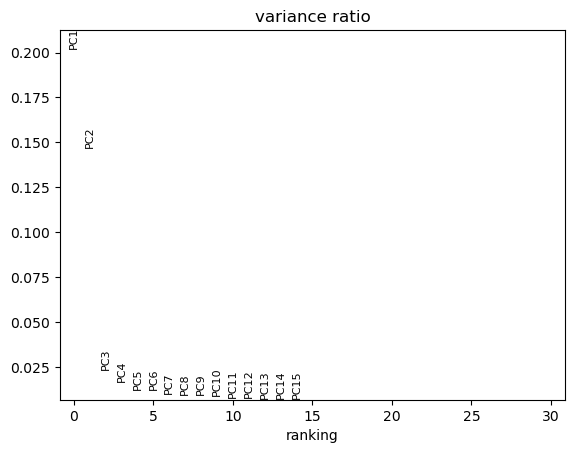

In [20]:
sc.pp.highly_variable_genes(
    adata,
    layer='log_norm',
    batch_key='dataset',
    n_top_genes=200,
)

sc.tl.pca(
    adata,
    layer='log_norm',
    n_comps=15,
    # mask_var='is_marker',
    mask_var='highly_variable',
)

sc.pl.pca_variance_ratio(adata)

# Initial UMAP

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:21)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


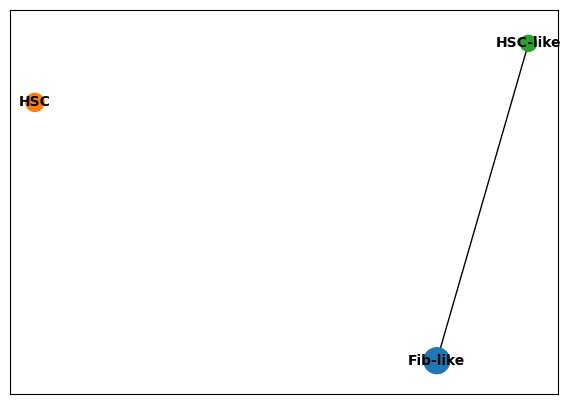

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)
running Leiden clustering


/tmp/ipykernel_756328/3875652710.py:20: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


    finished: found 11 clusters and added
    'new_cluster', the cluster labels (adata.obs, categorical) (0:00:00)


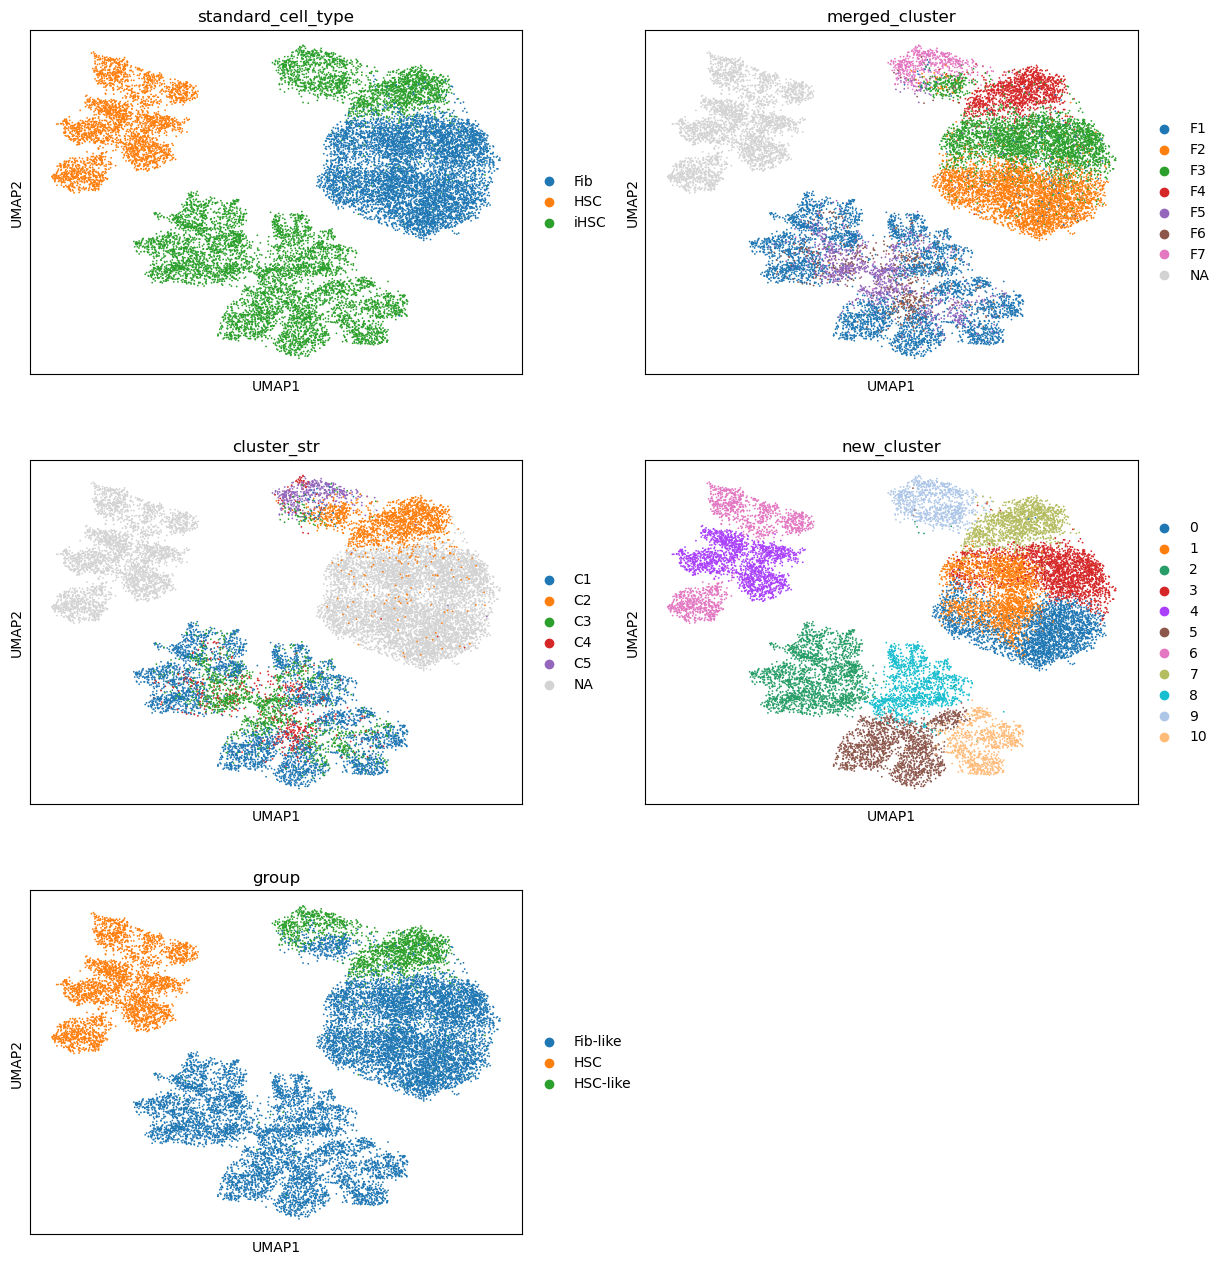

AnnData object with n_obs × n_vars = 18688 × 8638
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_id', 'cluster_str', 'merged_cluster', 'group', 'new_cluster'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'hematopoietic_stem_cells_marker', 'fibroblasts_marker', 'lung_fibroblast_marker', 'fat_fibroblast_marker', 'pancreas_fibroblast_marker', 'bone_marrow_hematopoietic_stem_cell_marker', 'thymus_fibroblast_marker', 'lymph_node_hematopoietic_stem_cell_marker', 'prostate_fibroblast_marker', 'lung_alveolar_fibroblast_marker', 'heart_fibroblast_of_cardiac_tissue_marker', 'trachea_fibroblast_marker', 'eye_fibroblast_marker', 'uterus_fibroblast_marker', 'bladder_fibroblast_marker', 'small_intestine_fibroblast_marker', 'large_intestine_fibroblast_marker', 'blood_hematopoietic_stem_cell_marker', 'spleen_hematopoieti

In [21]:
sc.pp.neighbors(
    adata, 
    n_neighbors=5,
)

sc.tl.paga(
    adata,
    groups='group',
)

sc.pl.paga(
    adata,
)

sc.tl.umap(
    adata,
    init_pos='paga',
)

sc.tl.leiden(
    adata, 
    resolution=0.35, 
    key_added='new_cluster',
)

sc.pl.umap(
    adata,
    color=[
        'standard_cell_type',
        'merged_cluster',
        'cluster_str',
        'new_cluster',
        'group',
    ],
    ncols=2,
)

adata

In [22]:
# break

# MAGIC

In [23]:
sce.pp.magic(
    adata,
    name_list='all_genes',
    solver='exact',
    copy=False,
)

adata.layers["magic"] = csr_matrix(adata.X.astype('float32').copy())

computing MAGIC
  Running MAGIC with `solver='exact'` on 8638-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
    finished (0:01:39)


# Write the file

In [24]:
outpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/scanpy/native_hsc_sc_fib.h5ad"
adata.write(outpath)
adata

AnnData object with n_obs × n_vars = 18688 × 8638
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_id', 'cluster_str', 'merged_cluster', 'group', 'new_cluster'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End', 'hematopoietic_stem_cells_marker', 'fibroblasts_marker', 'lung_fibroblast_marker', 'fat_fibroblast_marker', 'pancreas_fibroblast_marker', 'bone_marrow_hematopoietic_stem_cell_marker', 'thymus_fibroblast_marker', 'lymph_node_hematopoietic_stem_cell_marker', 'prostate_fibroblast_marker', 'lung_alveolar_fibroblast_marker', 'heart_fibroblast_of_cardiac_tissue_marker', 'trachea_fibroblast_marker', 'eye_fibroblast_marker', 'uterus_fibroblast_marker', 'bladder_fibroblast_marker', 'small_intestine_fibroblast_marker', 'large_intestine_fibroblast_marker', 'blood_hematopoietic_stem_cell_marker', 'spleen_hematopoieti